In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from scipy.sparse import csr_matrix, hstack
%matplotlib inline


def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)


def test_model_without_tuning(x_train, y_train):
    pipeline = make_pipeline(CountVectorizer(), LogisticRegression(random_state=0))
    param_grid = {'logisticregression__C': [1]}
    lr = GridSearchCV(pipeline, cv=10,  param_grid=param_grid, scoring="average_precision")
    lr_fit = lr.fit(x_train, y_train)
    
    print("Default Parameter: C=", round(lr_fit.best_params_['logisticregression__C'], 4))
    print("Average Precision: ", round(lr_fit.best_score_, 4))
    
    plt.figure(figsize=(15, 6))
    coef = lr_fit.best_estimator_.named_steps['logisticregression'].coef_.ravel()
    feature_names = lr_fit.best_estimator_.named_steps['countvectorizer'].get_feature_names()
    plot_important_features(coef, np.array(feature_names), top_n=10, rotation=40)
    plt.show()


def test_model(x_train, y_train):
    pipeline = make_pipeline(CountVectorizer(), LogisticRegression(random_state=0))
    
    param_grid = {'logisticregression__C': np.logspace(-2, 3, 10)}
    lr = GridSearchCV(pipeline, cv=10, param_grid=param_grid, scoring="average_precision")
    lr_fit = lr.fit(x_train, y_train)
    
    print("Best Parameter: C=", round(lr_fit.best_params_['logisticregression__C'], 4))
    print("Average Precision: ", round(lr_fit.best_score_, 4))
    
    plt.figure(figsize=(15, 6))
    coef = lr_fit.best_estimator_.named_steps['logisticregression'].coef_.ravel()
    feature_names = lr_fit.best_estimator_.named_steps['countvectorizer'].get_feature_names()
    plot_important_features(coef, np.array(feature_names), top_n=10, rotation=40)
    plt.show()
    
    x_train_vec = lr_fit.best_estimator_.named_steps['countvectorizer'].transform(x_train)
    
    return x_train_vec, feature_names

### Task 1 Title and Body

In [3]:
train = pd.read_csv("hw5/hw5_data_train.csv")
test = pd.read_csv("hw5/hw5_data_test.csv")
train = train.dropna(axis=0)
test = test.dropna(axis=0)

x_train = train.iloc[:, :2]
x_test = test.iloc[:, :2]
y_train = train.iloc[:, 2]
y_test = test.iloc[:, 2]

x_train_title = x_train.iloc[:, 0]
x_train_review = x_train.iloc[:, 1]
x_test_title = x_test.iloc[:, 0]
x_test_review = x_test.iloc[:, 1]

x_train_title_review = x_train.apply(lambda x: '%s %s' % (x[0], x[1]), axis=1)
x_test_title_review = x_test.apply(lambda x: '%s %s' % (x[0], x[1]), axis=1)

#### 1) Use the title only

Default Parameter: C= 1
Average Precision:  0.9802


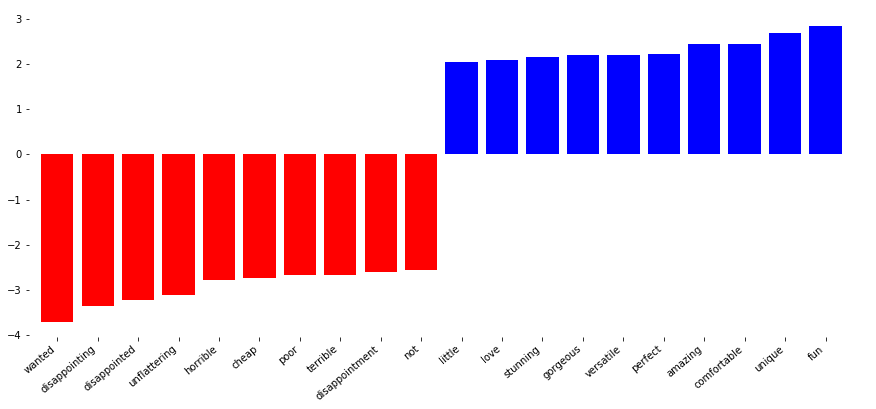

In [11]:
# Use CountVectorizer with the default settings and train a linear classifier
test_model_without_tuning(x_train_title, y_train)

Best Parameter: C= 1.6681
Average Precision:  0.9803


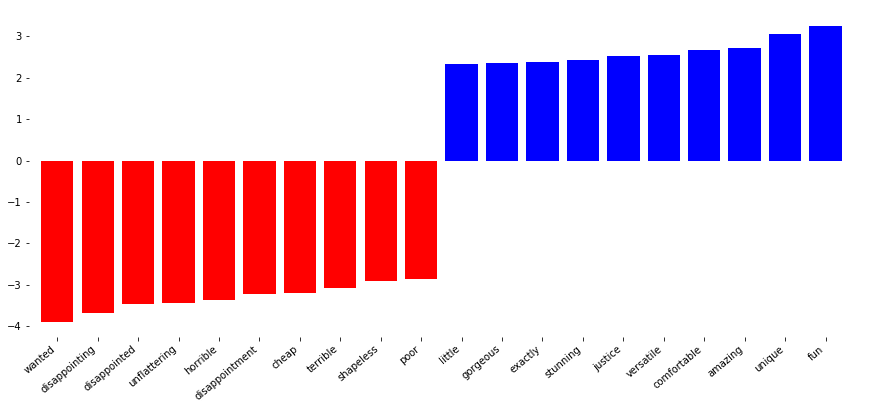

In [23]:
# Tune the regularization parameter of the classifier
title_vec, title_feature = test_model(x_train_title, y_train)

#### 2) Use the review body only

Default Parameter: C= 1
Average Precision:  0.9769


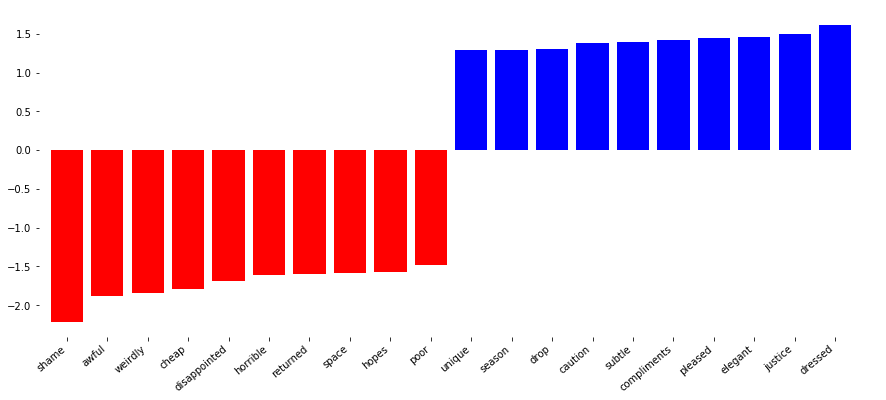

In [13]:
# Use CountVectorizer with the default settings and train a linear classifier
test_model_without_tuning(x_train_review, y_train)

Best Parameter: C= 0.1292
Average Precision:  0.9801


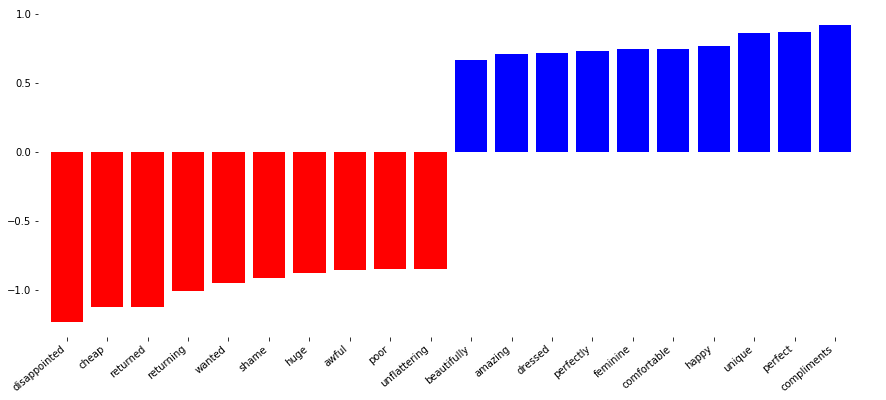

In [25]:
# Tune the regularization parameter of the classifier
review_vec, review_feature = test_model(x_train_review, y_train)

#### 3) Concatenate the title and review

Default Parameter: C= 1
Average Precision:  0.9832


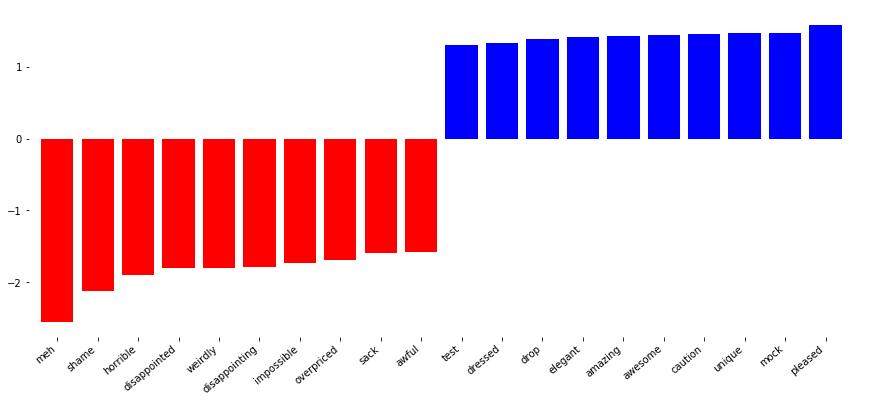

In [14]:
# Use CountVectorizer with the default settings and train a linear classifier
test_model_without_tuning(x_train_title_review, y_train)

Best Parameter: C= 0.1292
Average Precision:  0.9855


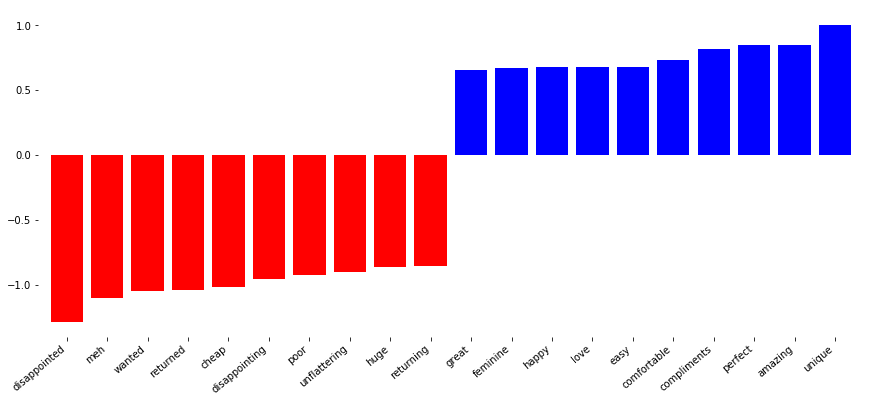

In [81]:
# Tune the regularization parameter of the classifier
title_review_vec, title_review_feature = test_model(x_train_title_review, y_train)

#### 4) Vectorizing title and review individually and concatenating the vector representations

Default Parameter: C = 1
Average Precision:  0.985


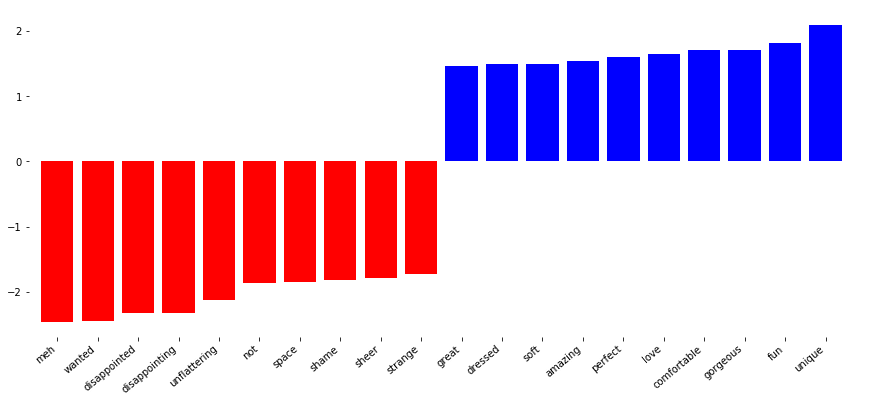

In [27]:
# Use CountVectorizer with the default settings and train a linear classifier
vector_indiv = csr_matrix(hstack([title_vec, review_vec]))
feature_names = title_feature + review_feature

param_grid = {'C': [1]}
lr = GridSearchCV(LogisticRegression(random_state=0), cv=10, param_grid=param_grid, scoring="average_precision")
lr_fit = lr.fit(vector_indiv, y_train)

print("Default Parameter: C =", round(lr_fit.best_params_['C'], 4))
print("Average Precision: ", round(lr_fit.best_score_, 4))

plt.figure(figsize=(15, 6))
plot_important_features(lr_fit.best_estimator_.coef_.ravel(), np.array(feature_names), top_n=10, rotation=40)
plt.show()

Best Parameter: C= 0.1292
Average Precision:  0.9862


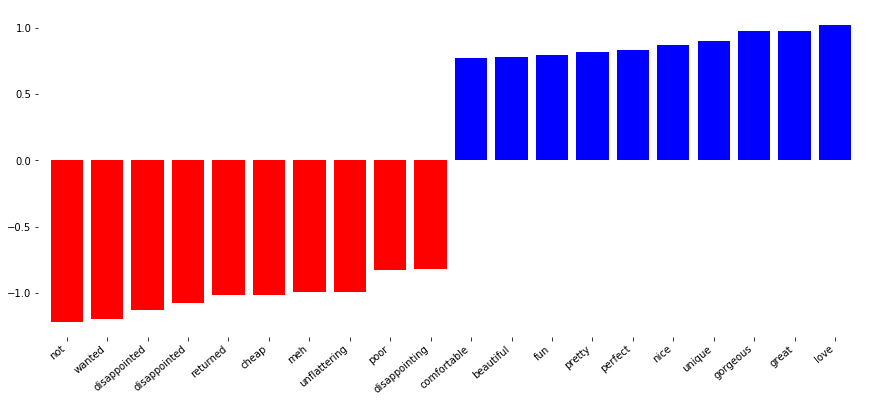

In [28]:
# Tune the regularization parameter of the classifier
param_grid = {'C': np.logspace(-2, 3, 10)}
lr = GridSearchCV(LogisticRegression(random_state=0), cv=10, param_grid=param_grid, scoring="average_precision")
lr_fit = lr.fit(vector_indiv, y_train)

print("Best Parameter: C=", round(lr_fit.best_params_['C'], 4))
print("Average Precision: ", round(lr_fit.best_score_, 4))

plt.figure(figsize=(15, 6))
plot_important_features(lr_fit.best_estimator_.coef_.ravel(), np.array(feature_names), top_n=10, rotation=40)
plt.show()

When the model is trained with data that vectorized title and review individually and concatenated the vector representations, the average precision was the highest. We could understand that the words that users use in the title and review carry different weights.

In [85]:
# Performance of the best model on Test Set 
vec = CountVectorizer()
vec.fit(x_train_title)
x_test_title_vec = vec.transform(x_test_title)

vec.fit(x_train_review)
x_test_review_vec = vec.transform(x_test_review)

vector_indiv = csr_matrix(hstack([x_test_title_vec, x_test_review_vec]))

print("Test Average Precision: ", round(average_precision_score(y_test, lr.predict_proba(vector_indiv)[:, 1]), 4))

Test Average Precision:  0.9863


### Task 2 Feature Tuning

#### 2.1 Try using TfidfVectorizer instead of CountVectorizer.

Best Parameter: C= 1.6681
Average Precision:  0.9882
Number of features:  12515


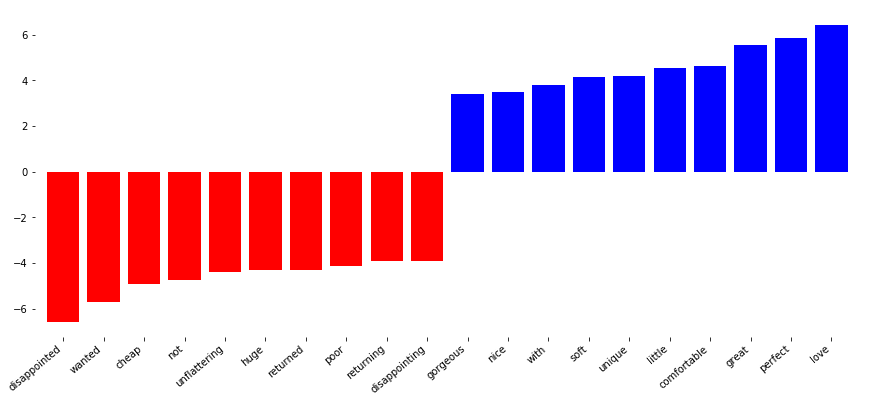

In [87]:
tfid = make_pipeline(TfidfVectorizer(), LogisticRegression(random_state=0))

param_grid = {'logisticregression__C': np.logspace(-2, 3, 10)}
lr = GridSearchCV(tfid, cv=10, param_grid=param_grid, scoring="average_precision")
task2_1 = lr.fit(x_train_title_review, y_train)

task2_1_coef = task2_1.best_estimator_.named_steps['logisticregression'].coef_.ravel()
task2_1_feature_names = task2_1.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()

print("Best Parameter: C=", round(task2_1.best_params_['logisticregression__C'], 4))
print("Average Precision: ", round(task2_1.best_score_, 4))
print("Number of features: ", len(task2_1_feature_names))

plt.figure(figsize=(15, 6))
plot_important_features(task2_1_coef, np.array(task2_1_feature_names), top_n=10, rotation=40)
plt.show()

TfidfVectorizer outperforms CounterVectorizer. The important coefficients change as well. With TfidVectorizer, the words such as not, with, soft and little appear in the top 20 important features. We also see that the coefficients of TfidVectorizer are much greater than those of CountVectorizer without normalization.

#### 2.2 Does using a Normalizer with CountVectorizer change the outcome?

Best Parameter: C = 5.9948
Average Precision:  0.9872
Number of features:  12515


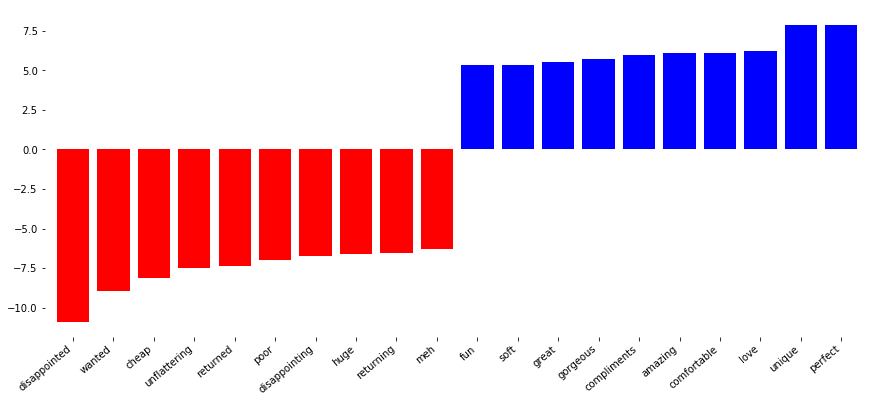

In [89]:
normalized = make_pipeline(CountVectorizer(), Normalizer(), LogisticRegression(random_state=0))

param_grid = {'logisticregression__C': np.logspace(-2, 3, 10)}
lr = GridSearchCV(normalized, cv=10, param_grid=param_grid, scoring="average_precision")
task2_2 = lr.fit(x_train_title_review, y_train)

task2_2_coef = task2_2.best_estimator_.named_steps['logisticregression'].coef_.ravel()
task2_2_feature_names = task2_2.best_estimator_.named_steps['countvectorizer'].get_feature_names()

print("Best Parameter: C =", round(task2_2.best_params_['logisticregression__C'], 4))
print("Average Precision: ", round(task2_2.best_score_, 4))
print("Number of features: ", len(task2_2_feature_names))

plt.figure(figsize=(15, 6))
plot_important_features(task2_2_coef, np.array(task2_2_feature_names), top_n=10, rotation=40)
plt.show()

Normalizing the feature space improves the performace from 0.9855 to 0.9872.

#### 2.3 Try using stop-word.

Best Parameter: C = 5.9948
Average Precision:  0.9857
Number of features:  12233


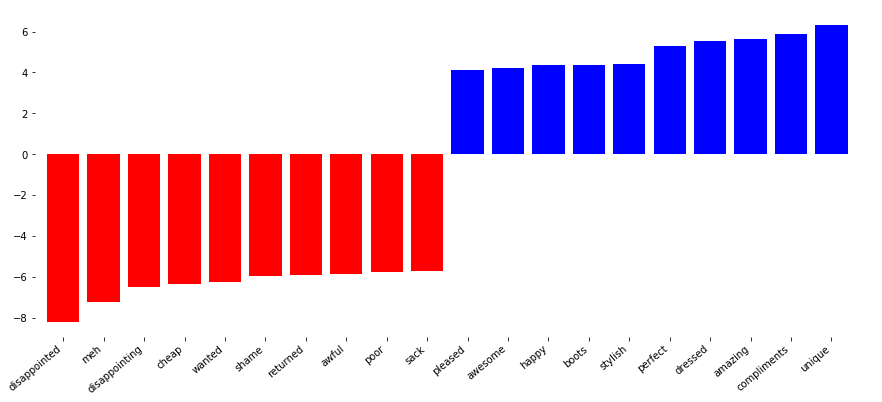

In [91]:
normalized = make_pipeline(CountVectorizer(stop_words='english'), Normalizer(), LogisticRegression(random_state=0))

param_grid = {'logisticregression__C': np.logspace(-2, 3, 10)}
lr = GridSearchCV(normalized, cv=10, param_grid=param_grid, scoring="average_precision")
task2_3 = lr.fit(x_train_title_review, y_train)

task2_3_coef = task2_3.best_estimator_.named_steps['logisticregression'].coef_.ravel()
task2_3_feature_names = task2_3.best_estimator_.named_steps['countvectorizer'].get_feature_names()

print("Best Parameter: C =", round(task2_3.best_params_['logisticregression__C'], 4))
print("Average Precision: ", round(task2_3.best_score_, 4))
print("Number of features: ", len(task2_3_feature_names))

plt.figure(figsize=(15, 6))
plot_important_features(task2_3_coef, np.array(task2_3_feature_names), top_n=10, rotation=40)
plt.show()

Using English stop-words does not help. As shown below, the removed words are actually important in explaining the outcome. 

In [42]:
n = 50
inds = np.argsort(task2_2_coef)
low = inds[:n]
high = inds[-n:]
important = np.hstack([low, high])
features = np.array(task2_2_feature_names)[important]

for feature in features:
    if feature not in task2_3_feature_names:
        print('feature "{}" was removed !'.format(feature))

feature "nothing" was removed !
feature "least" was removed !
feature "not" was removed !
feature "back" was removed !
feature "after" was removed !
feature "no" was removed !
feature "enough" was removed !
feature "sometimes" was removed !


Out of top 100 important coefficients, 8 of them were stop-words.

Best Parameter: C = 5.9948
Best Parameter: min_df = 2
Average Precision:  0.9872
Number of features:  7182


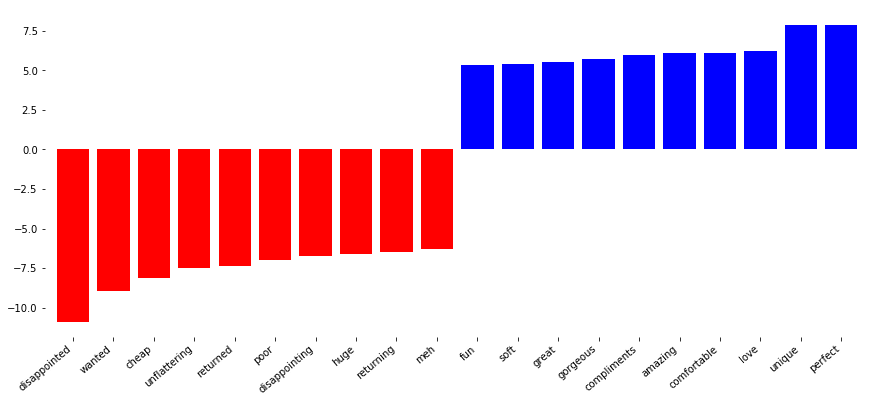

In [32]:
normalized = make_pipeline(CountVectorizer(), Normalizer(), LogisticRegression(random_state=0))

param_grid = {'countvectorizer__min_df': [2, 3, 4], 'logisticregression__C': np.logspace(-2, 3, 10)}
lr = GridSearchCV(normalized, cv=10, param_grid=param_grid, scoring="average_precision")
task2_4 = lr.fit(x_train_title_review, y_train)

coef = task2_4.best_estimator_.named_steps['logisticregression'].coef_.ravel()
feature_names = task2_4.best_estimator_.named_steps['countvectorizer'].get_feature_names()

print("Best Parameter: C =", round(task2_4.best_params_['logisticregression__C'], 4))
print("Best Parameter: min_df =", task2_4.best_params_['countvectorizer__min_df'])
print("Average Precision: ", round(task2_4.best_score_, 4))
print("Number of features: ", len(feature_names))

plt.figure(figsize=(15, 6))
plot_important_features(coef, np.array(feature_names), top_n=10, rotation=40)
plt.show()

For this specific data, limiting the vocabulary using min_df hurts the performance of our model. The feature space is decreased from 12,515 to 7,182 by limiting the vocabulary. This is a trade-off between accuracy and scalability of the model.

In [44]:
# Performance of the best model on Test Set using the best parameter C = 1.6681
tfid = make_pipeline(TfidfVectorizer(), LogisticRegression(C=1.6681, random_state=0))
tfid.fit(x_train_title_review, y_train)

print("Test Average Precision: ", 
      round(average_precision_score(y_test, tfid.predict_proba(x_test_title_review)[:, 1]), 4))

Test Average Precision:  0.9871


### Task 3 n-grams

#### 3.1 Using your current best model, try changing from unigrams to n-grams of varying length.

In [6]:
tfid = make_pipeline(TfidfVectorizer(), LogisticRegression(random_state=0))

param_grid = {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (2, 3), (2, 5)], 
              'logisticregression__C':  np.logspace(-1, 3, 7)}
lr = GridSearchCV(tfid, cv=10, param_grid=param_grid, scoring="average_precision")
task3_1 = lr.fit(x_train_title_review, y_train)

task3_1_coef = task3_1.best_estimator_.named_steps['logisticregression'].coef_.ravel()
task3_1_feature_names = task3_1.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()

print("Best Parameter: C =", round(task3_1.best_params_['logisticregression__C'], 4))
print("Best Parameter: ngram_range =", task3_1.best_params_['tfidfvectorizer__ngram_range'])
print("Average Precision: ", round(task3_1.best_score_, 4))
print("Number of features: ", len(task3_1_feature_names))

Best Parameter: C = 10.0
Best Parameter: ngram_range = (1, 2)
Average Precision:  0.9898
Number of features:  196228


The best parameter for ngram_range is (1, 2). Using n-grams improves the performance from 0.9882 to 0.9898.

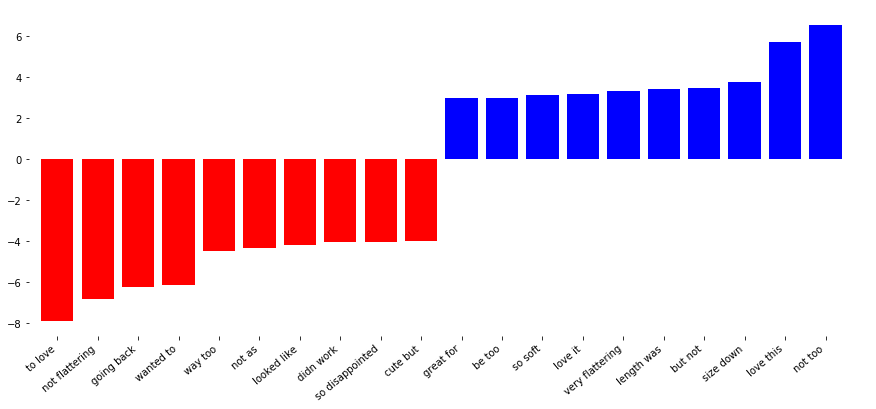

In [73]:
# higher-order n-grams must contain a space
n_gram = pd.DataFrame(task3_1_feature_names)
n_gram['higher'] = n_gram.apply(lambda x: ' ' in x[0], axis=1)
higher = np.array(n_gram.index[n_gram['higher']])

coef = task3_1_coef[higher]
features = np.array(task3_1_feature_names)[higher]

plt.figure(figsize=(15, 6))
plot_important_features(coef, np.array(features), top_n=10, rotation=40)
plt.show()

#### 3.2 Try using character n-grams.

In [8]:
tfid = make_pipeline(TfidfVectorizer(analyzer="char_wb"), LogisticRegression(random_state=0))

param_grid = {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (2, 3), (2, 5)], 
              'logisticregression__C': np.logspace(-1, 3, 7)}
lr = GridSearchCV(tfid, cv=10, param_grid=param_grid, scoring="average_precision")
task3_2 = lr.fit(x_train_title_review, y_train)

task3_2_coef = task3_2.best_estimator_.named_steps['logisticregression'].coef_.ravel()
task3_2_feature_names = task3_2.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()

print("Best Parameter: C =", round(task3_2.best_params_['logisticregression__C'], 4))
print("Best Parameter: ngram_range =", task3_2.best_params_['tfidfvectorizer__ngram_range'])
print("Average Precision: ", round(task3_2.best_score_, 4))
print("Number of features: ", len(task3_2_feature_names))

Best Parameter: C = 2.1544
Best Parameter: ngram_range = (2, 5)
Average Precision:  0.988
Number of features:  109489


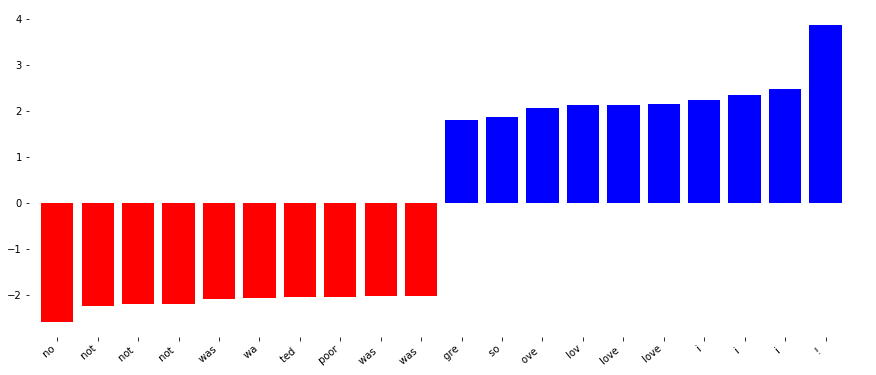

In [95]:
n_gram = pd.DataFrame(task3_2_feature_names)
n_gram['higher'] = n_gram.apply(lambda x: ' ' in x[0], axis=1)
higher = np.array(n_gram.index[n_gram['higher']])

coef = task3_2_coef[higher]
features = np.array(task3_2_feature_names)[higher]

plt.figure(figsize=(15, 6))
plot_important_features(coef, np.array(features), top_n=10, rotation=40)
plt.show()

From this exercise, we can conclude that only few words are significant such as love and not, because we see subsets of these words appear repitively. Also, special characters are really important in predicting positive reviews.

#### 3.3 Investigate how min_df and the use of stop-words changes the number of features when using word n-grams.

In [34]:
tfid = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), LogisticRegression(C=10, random_state=0))

param_grid = {'tfidfvectorizer__min_df': [2, 3]}
lr = GridSearchCV(tfid, cv=10, param_grid=param_grid, scoring="average_precision")
task3_3 = lr.fit(x_train_title_review, y_train)

task3_3_coef = task3_3.best_estimator_.named_steps['logisticregression'].coef_.ravel()
task3_3_feature_names = task3_3.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()

print("Best Parameter: min_df =", task3_3.best_params_['tfidfvectorizer__min_df'])
print("Average Precision: ", round(task3_3.best_score_, 4))
print("Number of features: ", len(task3_3_feature_names))

Best Parameter: min_df = 2
Average Precision:  0.9897
Number of features:  70273


Similarly to task 2.4, limiting the vocabulary using min_df does not improve the performance. It only decreases the performance by 0.001. However, the feature spaces is greatly reduced from 196,228 to 70,273. Limiting the vocabulary could be considered here.

In [35]:
tfid = make_pipeline(TfidfVectorizer(ngram_range=(1, 2), stop_words='english'), LogisticRegression(C=10, random_state=0))

param_grid = {'tfidfvectorizer__min_df': [2, 3]}
lr = GridSearchCV(tfid, cv=10, param_grid=param_grid, scoring="average_precision")
task3_32 = lr.fit(x_train_title_review, y_train)

task3_32_coef = task3_32.best_estimator_.named_steps['logisticregression'].coef_.ravel()
task3_32_feature_names = task3_32.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()

print("Best Parameter: min_df =", task3_32.best_params_['tfidfvectorizer__min_df'])
print("Average Precision: ", round(task3_32.best_score_, 4))
print("Number of features: ", len(task3_32_feature_names))

Best Parameter: min_df = 2
Average Precision:  0.9873
Number of features:  53565


Using English stop-words also hurts the performance of the model.

In [20]:
n = 50
inds = np.argsort(task3_3_coef)
low = inds[:n]
high = inds[-n:]
important = np.hstack([low, high])
features = np.array(task3_3_feature_names)[important]

for feature in features:
    if feature not in task3_32_feature_names:
        print('feature "{}" was removed !'.format(feature))

feature "not" was removed !
feature "to love" was removed !
feature "not flattering" was removed !
feature "was" was removed !
feature "going back" was removed !
feature "wanted to" was removed !
feature "back" was removed !
feature "way too" was removed !
feature "nothing" was removed !
feature "were" was removed !
feature "not as" was removed !
feature "no" was removed !
feature "so disappointed" was removed !
feature "cute but" was removed !
feature "the top" was removed !
feature "would be" was removed !
feature "not worth" was removed !
feature "not great" was removed !
feature "can" was removed !
feature "so soft" was removed !
feature "love it" was removed !
feature "my" was removed !
feature "enough" was removed !
feature "very flattering" was removed !
feature "length was" was removed !
feature "but not" was removed !
feature "size down" was removed !
feature "love this" was removed !
feature "not too" was removed !
feature "with" was removed !


Out of top 100 important coefficients, 30 of them were removed by using English stop-words. However, the feature space is a lot smaller, which is 53,565.

Our final model is TfidVectorizer with ngram_range = (1, 2), min_df = 1 and the regularization parameter, C = 10.

In [96]:
tfid = make_pipeline(TfidfVectorizer(ngram_range=(1, 2), min_df=1), LogisticRegression(C=10, random_state=0))
tfid.fit(x_train_title_review, y_train)

print("Test Average Precision: ", 
      round(average_precision_score(y_test, tfid.predict_proba(x_test_title_review)[:, 1]), 4))

Test Average Precision:  0.989


### Task 4 Model Tuning

Using L1 penalty

In [4]:
tfid = make_pipeline(TfidfVectorizer(ngram_range=(1, 2), min_df=1), LogisticRegression(C=10, penalty='l1', 
                                                                                       random_state=0))
tfid.fit(x_train_title_review, y_train)

print("L1 Average Precision: ", 
      average_precision_score(y_train, tfid.predict_proba(x_train_title_review)[:, 1]))

L1 Average Precision:  0.999982078529


Using L1 penalty greatly improves the score. We have a large feature space and might want to acheive sparcity.

In [43]:
from sklearn.svm import SVC
tfid = make_pipeline(TfidfVectorizer(ngram_range=(1, 2), min_df=1), SVC(kernel='linear', random_state=0))
tfid.fit(x_train_title_review, y_train)

print("SVC Average Precision: ", 
      average_precision_score(y_train, tfid.decision_function(x_train_title_review)))

SVC Average Precision:  0.99966614852


Best model is TfidVectorizer with ngram_range=(1,2), min_df=1 and the regularization parameter C = 10 with L1 penatly. Evaluate the model on test set.

In [7]:
print("Final Model Test Average Precision: ", 
      average_precision_score(y_test, tfid.predict_proba(x_test_title_review)[:, 1]))

Final Model Test Average Precision:  0.985532570364


Some other features to try:
1.) Length of text in title
2.) Length of text in review
3.) Presence/Frequency of ALL-CAPS
4.) Number of out-of-vocabulary words
5.) Sentiment words(good and bad)
6.) Number of special characters